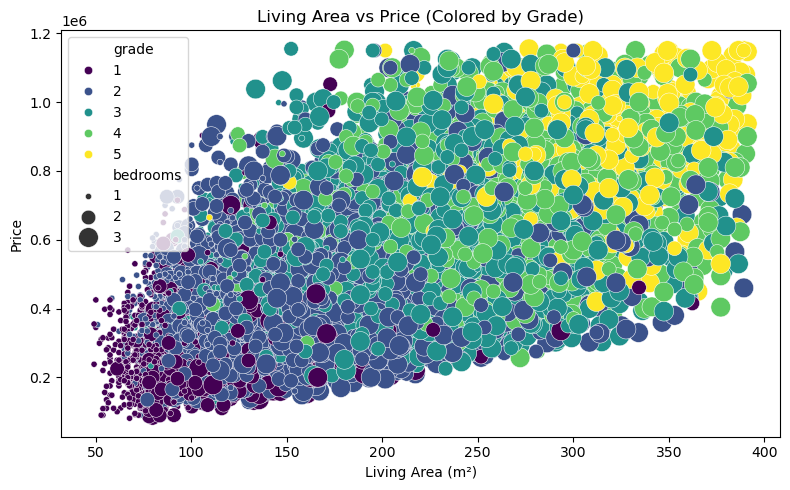

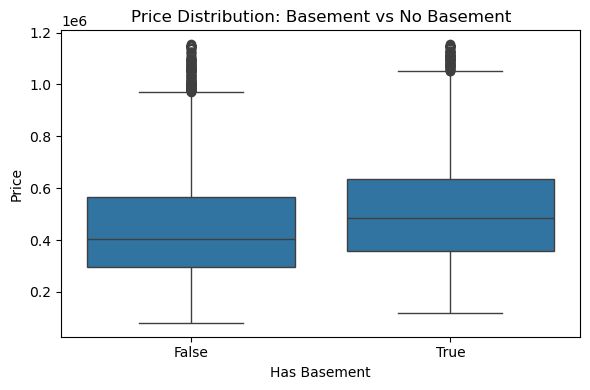

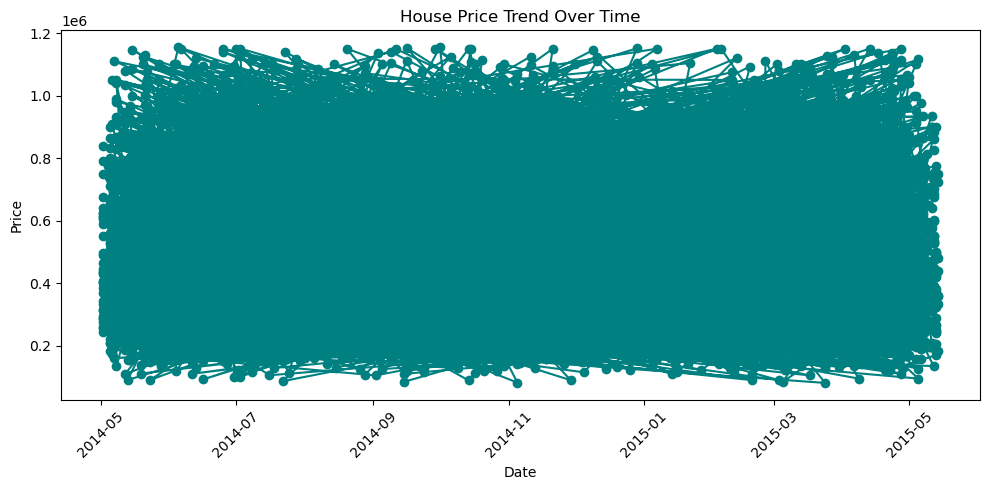

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
df = pd.read_csv('df_train.csv', parse_dates=['date'])



# Plot 2: Living Area vs Price (Colored by Grade)
plt.figure(figsize=(8, 5))
sns.scatterplot(
    x='living_in_m2',
    y='price',
    hue='grade',
    size='bedrooms',
    data=df,
    palette='viridis',
    sizes=(20, 200)
)
plt.title('Living Area vs Price (Colored by Grade)')
plt.xlabel('Living Area (m²)')
plt.ylabel('Price')
plt.tight_layout()
plt.show()

# Plot 3: Price Distribution: Basement vs No Basement
plt.figure(figsize=(6, 4))
sns.boxplot(x='has_basement', y='price', data=df)
plt.title('Price Distribution: Basement vs No Basement')
plt.xlabel('Has Basement')
plt.ylabel('Price')
plt.tight_layout()
plt.show()


plt.figure(figsize=(10, 5))
plt.plot(df['date'], df['price'], marker='o', color='teal')
plt.title('House Price Trend Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



C:\Users\IQBAL\AppData\Local\Temp\ipykernel_5552\186793690.py:19: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data.replace({'TRUE': 1, 'FALSE': 0, True: 1, False: 0}, inplace=True)



Linear Regression:
  MSE: 0.05
  RMSE: 0.22
  R² Score: 0.74

Grid Search - Random Forest:
  Best Parameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
  Test Set Performance of Best RF:
    MSE: 0.04
    RMSE: 0.21
    R² Score: 0.77

XGBoost:
  MSE: 0.05
  RMSE: 0.21
  R² Score: 0.75

📊 Model Performance Summary:
               Model  R2 Score      RMSE       MSE
0  Linear Regression  0.744816  0.218876  0.047907
1      Random Forest  0.766154  0.209526  0.043901
2            XGBoost  0.753894  0.214948  0.046203


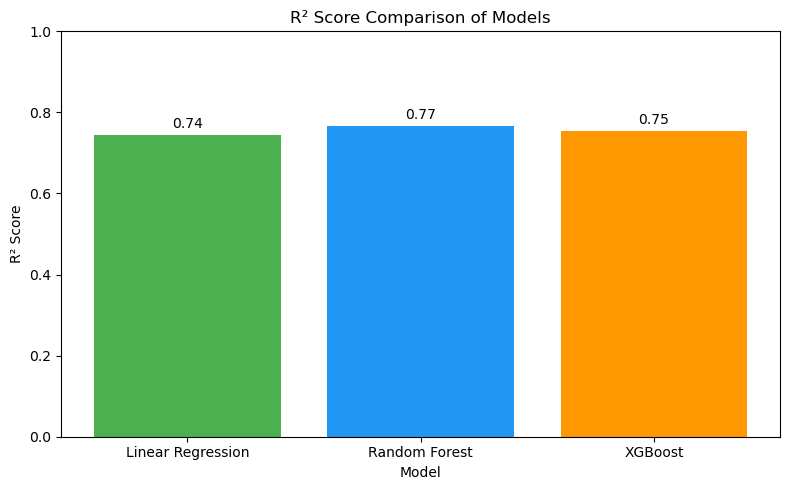

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt

# ------------------ Load Dataset ------------------
data = pd.read_csv('df_train.csv')

# ------------------ Preprocessing ------------------
data.replace({'TRUE': 1, 'FALSE': 0, True: 1, False: 0}, inplace=True)
data['price'] = np.log1p(data['price'])
data['living_in_m2'] = np.log1p(data['living_in_m2'])
data.drop(columns=['date'], inplace=True)

X = data.drop(columns=['price'])
y = data['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()

numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# ------------------ Initialize Results ------------------
results = {
    'Model': [],
    'R2 Score': [],
    'RMSE': [],
    'MSE': []
}

# ------------------ Linear Regression ------------------
lr = LinearRegression()
lr.fit(X_train_processed, y_train)
y_pred_lr = lr.predict(X_test_processed)

r2_lr = r2_score(y_test, y_pred_lr)
rmse_lr = sqrt(mean_squared_error(y_test, y_pred_lr))
mse_lr = mean_squared_error(y_test, y_pred_lr)

print("\nLinear Regression:")
print(f"  MSE: {mse_lr:.2f}")
print(f"  RMSE: {rmse_lr:.2f}")
print(f"  R² Score: {r2_lr:.2f}")

results['Model'].append('Linear Regression')
results['R2 Score'].append(r2_lr)
results['RMSE'].append(rmse_lr)
results['MSE'].append(mse_lr)

# ------------------ Random Forest with GridSearchCV ------------------
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

grid = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=3, scoring='r2')
grid.fit(X_train_processed, y_train)

best_rf = grid.best_estimator_
y_pred_rf = best_rf.predict(X_test_processed)

r2_rf = r2_score(y_test, y_pred_rf)
rmse_rf = sqrt(mean_squared_error(y_test, y_pred_rf))
mse_rf = mean_squared_error(y_test, y_pred_rf)

print("\nGrid Search - Random Forest:")
print("  Best Parameters:", grid.best_params_)
print("  Test Set Performance of Best RF:")
print(f"    MSE: {mse_rf:.2f}")
print(f"    RMSE: {rmse_rf:.2f}")
print(f"    R² Score: {r2_rf:.2f}")

results['Model'].append('Random Forest')
results['R2 Score'].append(r2_rf)
results['RMSE'].append(rmse_rf)
results['MSE'].append(mse_rf)

# ------------------ XGBoost ------------------
xgb = XGBRegressor(random_state=42, objective='reg:squarederror')
xgb.fit(X_train_processed, y_train)
y_pred_xgb = xgb.predict(X_test_processed)

r2_xgb = r2_score(y_test, y_pred_xgb)
rmse_xgb = sqrt(mean_squared_error(y_test, y_pred_xgb))
mse_xgb = mean_squared_error(y_test, y_pred_xgb)

print("\nXGBoost:")
print(f"  MSE: {mse_xgb:.2f}")
print(f"  RMSE: {rmse_xgb:.2f}")
print(f"  R² Score: {r2_xgb:.2f}")

results['Model'].append('XGBoost')
results['R2 Score'].append(r2_xgb)
results['RMSE'].append(rmse_xgb)
results['MSE'].append(mse_xgb)

# ------------------ Show Results Table ------------------
results_df = pd.DataFrame(results)
print("\n📊 Model Performance Summary:")
print(results_df)

# ------------------ Plot R² Comparison ------------------
plt.figure(figsize=(8, 5))
bars = plt.bar(results['Model'], results['R2 Score'], color=['#4caf50', '#2196f3', '#ff9800'])
plt.ylim(0, 1)
plt.title('R² Score Comparison of Models')
plt.ylabel('R² Score')
plt.xlabel('Model')

# Add value labels on top of bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.01, f'{yval:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()


C:\Users\IQBAL\AppData\Local\Temp\ipykernel_5552\1077431418.py:17: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data.replace({'TRUE': 1, 'FALSE': 0, True: 1, False: 0}, inplace=True)



Linear Regression:
  MSE: 0.05
  RMSE: 0.22
  R² Score: 0.75

Grid Search - Random Forest:
  Best Parameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
  Test Set Performance of Best RF:
    MSE: 0.05
    RMSE: 0.21
    R² Score: 0.76

XGBoost:
  MSE: 0.05
  RMSE: 0.22
  R² Score: 0.75

📊 Model Performance Summary:
               Model  R2 Score      RMSE       MSE
0  Linear Regression  0.747114  0.218699  0.047829
1      Random Forest  0.760034  0.213039  0.045386
2            XGBoost  0.747284  0.218626  0.047797


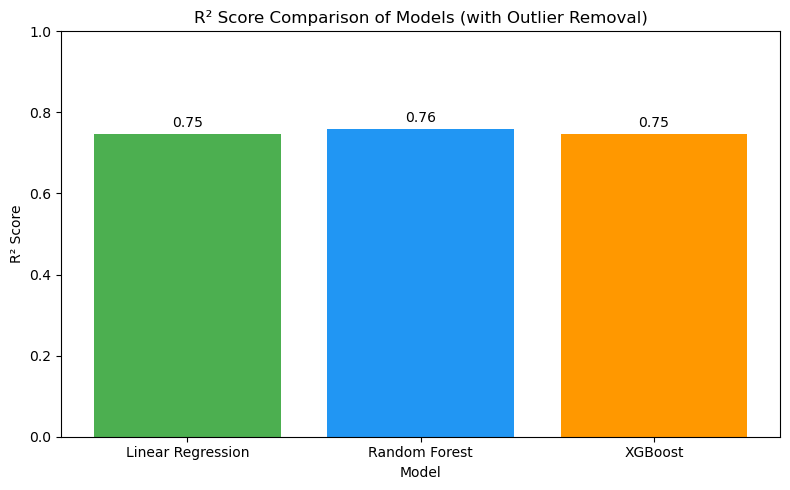

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt

# ------------------ Load and Clean Dataset ------------------
data = pd.read_csv('df_train.csv')
data.replace({'TRUE': 1, 'FALSE': 0, True: 1, False: 0}, inplace=True)

# ------------------ Outlier Removal (IQR) ------------------
Q1 = data['price'].quantile(0.25)
Q3 = data['price'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
data = data[(data['price'] >= lower_bound) & (data['price'] <= upper_bound)]

# ------------------ Feature Engineering ------------------
data['price'] = np.log1p(data['price'])
data['living_in_m2'] = np.log1p(data['living_in_m2'])
data.drop(columns=['date'], inplace=True)

X = data.drop(columns=['price'])
y = data['price']

# ------------------ Train-Test Split ------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ------------------ Preprocessing Pipelines ------------------
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()

numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

# ------------------ Transform Data ------------------
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# ------------------ Initialize Results ------------------
results = {
    'Model': [],
    'R2 Score': [],
    'RMSE': [],
    'MSE': []
}

# ------------------ Linear Regression ------------------
lr = LinearRegression()
lr.fit(X_train_processed, y_train)
y_pred_lr = lr.predict(X_test_processed)

r2_lr = r2_score(y_test, y_pred_lr)
rmse_lr = sqrt(mean_squared_error(y_test, y_pred_lr))
mse_lr = mean_squared_error(y_test, y_pred_lr)

print("\nLinear Regression:")
print(f"  MSE: {mse_lr:.2f}")
print(f"  RMSE: {rmse_lr:.2f}")
print(f"  R² Score: {r2_lr:.2f}")

results['Model'].append('Linear Regression')
results['R2 Score'].append(r2_lr)
results['RMSE'].append(rmse_lr)
results['MSE'].append(mse_lr)

# ------------------ Random Forest with GridSearchCV ------------------
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

grid = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=3, scoring='r2')
grid.fit(X_train_processed, y_train)
best_rf = grid.best_estimator_
y_pred_rf = best_rf.predict(X_test_processed)

r2_rf = r2_score(y_test, y_pred_rf)
rmse_rf = sqrt(mean_squared_error(y_test, y_pred_rf))
mse_rf = mean_squared_error(y_test, y_pred_rf)

print("\nGrid Search - Random Forest:")
print("  Best Parameters:", grid.best_params_)
print("  Test Set Performance of Best RF:")
print(f"    MSE: {mse_rf:.2f}")
print(f"    RMSE: {rmse_rf:.2f}")
print(f"    R² Score: {r2_rf:.2f}")

results['Model'].append('Random Forest')
results['R2 Score'].append(r2_rf)
results['RMSE'].append(rmse_rf)
results['MSE'].append(mse_rf)

# ------------------ XGBoost ------------------
xgb = XGBRegressor(random_state=42, objective='reg:squarederror')
xgb.fit(X_train_processed, y_train)
y_pred_xgb = xgb.predict(X_test_processed)

r2_xgb = r2_score(y_test, y_pred_xgb)
rmse_xgb = sqrt(mean_squared_error(y_test, y_pred_xgb))
mse_xgb = mean_squared_error(y_test, y_pred_xgb)

print("\nXGBoost:")
print(f"  MSE: {mse_xgb:.2f}")
print(f"  RMSE: {rmse_xgb:.2f}")
print(f"  R² Score: {r2_xgb:.2f}")

results['Model'].append('XGBoost')
results['R2 Score'].append(r2_xgb)
results['RMSE'].append(rmse_xgb)
results['MSE'].append(mse_xgb)

# ------------------ Results Table ------------------
results_df = pd.DataFrame(results)
print("\n📊 Model Performance Summary:")
print(results_df)

# ------------------ Plot R² Comparison ------------------
plt.figure(figsize=(8, 5))
bars = plt.bar(results['Model'], results['R2 Score'], color=['#4caf50', '#2196f3', '#ff9800'])
plt.ylim(0, 1)
plt.title('R² Score Comparison of Models (with Outlier Removal)')
plt.ylabel('R² Score')
plt.xlabel('Model')

# Add value labels
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.01, f'{yval:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()
